<a href="https://colab.research.google.com/github/saadqaqa-etu/nettoyer-les-donn-es-textuelles-prevenants-des-tweets-/blob/main/pfa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Input, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Download NLTK stopwords
nltk.download('stopwords')

# Define preprocessing functions
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove mentions (@username) and hashtags (#)
    text = re.sub(r'@[^\s]+', '', text)
    text = re.sub(r'#', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization
    tokens = text.split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Rejoin tokens into a single string
    text = ' '.join(tokens)

    return text

# Load your data from the JSON file
json_file_path = 'drive/MyDrive/train.json'
df = pd.read_json(json_file_path)

# Assuming 'df' is your DataFrame and 'processing' is your processing function
df['tweet'] = df['tweet'].astype(str)
df['tweet'] = df['tweet'].apply(preprocess_text)

# Define parameters for tokenization and padding
max_vocabulary = 4000
max_length = 50
embedding_size = 100

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_vocabulary)
tokenizer.fit_on_texts(df['tweet'])
sequences = tokenizer.texts_to_sequences(df['tweet'])
Data_T = pad_sequences(sequences, maxlen=max_length)

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(Data_T, df.label, test_size=0.2501, random_state=42)

# Download GloVe embeddings and create an embedding matrix
glove_file = 'drive/MyDrive/glove.twitter.27B.100d.txt'  # Replace with the path to your GloVe file
word_vectors = {}
with open(glove_file, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        word_vectors[word] = vector

vocabulary_size = max_vocabulary
embedding_dim = 100

embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocabulary_size:
        embedding_vector = word_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:

# Define your deep learning model based on your architecture description
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)
# Hyperparameter Tuning
learning_rate = 0.001  # Adjust the learning rate
batch_size = 64  # Adjust batch size
epochs = 50  # Adjust the number of epochs

# Define your deep learning model based on your architecture description
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocabulary_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)


# Add Conv1D layer(s)
conv1d_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)

# Add LSTM layers
lstm_layer1 = LSTM(100, return_sequences=True)(conv1d_layer)
dropout1 = Dropout(0.5)(lstm_layer1)

lstm_layer2 = LSTM(100, return_sequences=True)(dropout1)
dropout2 = Dropout(0.5)(lstm_layer2)

# Add GlobalMaxPooling1D layer
maxpooling_layer = GlobalMaxPooling1D()(dropout2)

# Add a Dense layer for classification
output_layer = Dense(1, activation='sigmoid')(maxpooling_layer)

# Compile the model with adjusted learning rate
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Implement cross-validation
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(Data_T, df.label):
    x_train, x_val = Data_T[train_index], Data_T[val_index]
    y_train, y_val = df.label[train_index], df.label[val_index]

    # Train the model
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), verbose=1)

    # Evaluate the model on the test set
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f'Test loss: {loss}, Test accuracy: {accuracy}')

    # Predict on the test set
    y_pred = (model.predict(x_test) > 0.5).astype(int)

    # Calculate and display classification report
    classification_rep = classification_report(y_test, y_pred)
    print(classification_rep)


Epoch 1/50
104/104 [==============================] - 15s 101ms/step - loss: 0.6489 - accuracy: 0.6181 - val_loss: 0.6368 - val_accuracy: 0.6322
Epoch 2/50
104/104 [==============================] - 10s 91ms/step - loss: 0.6222 - accuracy: 0.6495 - val_loss: 0.6470 - val_accuracy: 0.6407
Epoch 3/50
104/104 [==============================] - 10s 93ms/step - loss: 0.6026 - accuracy: 0.6712 - val_loss: 0.6249 - val_accuracy: 0.6600
Epoch 4/50
104/104 [==============================] - 9s 91ms/step - loss: 0.5903 - accuracy: 0.6788 - val_loss: 0.6341 - val_accuracy: 0.6504
Epoch 5/50
104/104 [==============================] - 10s 93ms/step - loss: 0.5735 - accuracy: 0.6948 - val_loss: 0.6227 - val_accuracy: 0.6552
Epoch 6/50
104/104 [==============================] - 9s 91ms/step - loss: 0.5387 - accuracy: 0.7285 - val_loss: 0.6158 - val_accuracy: 0.6546
Epoch 7/50
104/104 [==============================] - 9s 90ms/step - loss: 0.4811 - accuracy: 0.7700 - val_loss: 0.6515 - val_accuracy: 0

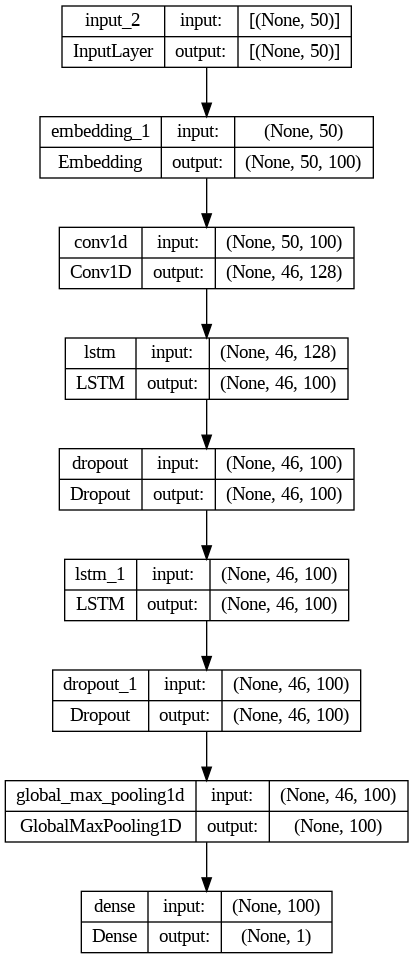

In [ ]:
from keras.utils import plot_model

# Visualize the model and save it to a file
plot_model(model, to_file='model_visualization.png', show_shapes=True)


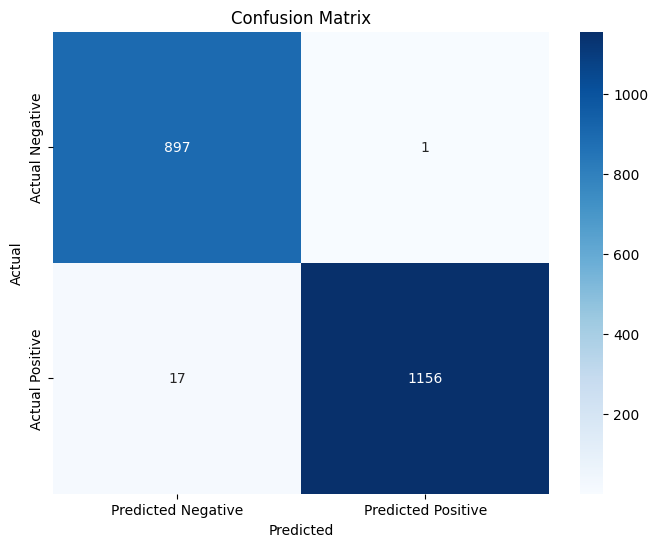

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true contains true labels (0 or 1) and y_pred contains predicted labels
# for your test dataset

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


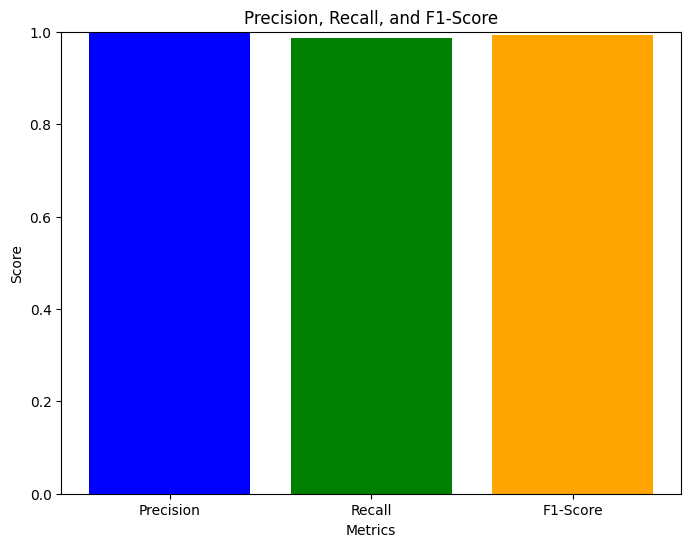

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt



# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Create a bar chart to visualize precision, recall, and F1-score
metrics = ['Precision', 'Recall', 'F1-Score']
values = [precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange'])
plt.ylim(0, 1)  # Set the y-axis limit between 0 and 1
plt.title('Precision, Recall, and F1-Score')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.show()
